# Посчитать деньги

Миша работает дата-сайентистом и купается в деньгах, поэтому они часто оказываются разбросанными по полу. Мише надоело их собирать и считать, и он хочет реализовать алгоритм компьютерного зрения, который бы определял, какая сумма денег изображена на картинке. Помогите Мише!

## Формат ввода

[Ссылка на данные](https://disk.yandex.ru/d/tBGG00DwHLzB3w)

Данные представляют из себя изображения c путями [train,test]/pictures/[train,test]_{n}.png. Купюры на каждом изображении --- это изображения купюр номиналом 100, 500 и 1000 рублей (купюры могут лежать обеими сторонами). В файле train/answers.csv указаны правильные ответы для изображений: количество купюр вида 100, 500, 1000 рублей (включая обороты, всего 6 столбцов).

## Формат вывода

Вам необходимо послать в тестирующую систему файл submission.csv, 
$k$-я строка которого будет содержать сумму номиналов всех купюр, изображенных на изображении k.png. Нулевая строка должна содержать название колонки. Файл SampleSubmission.csv представляет из себя пример посылки.

## Примечания

Метрика оценки качества &mdash; Mean Absolute Error, которая вычисляется по формуле

$$\frac{1}{l} \sum \left| y_{true} - y_{pred}\right|.$$

Оценка ставится по формуле

$$10 \cdot \frac{BaselineScore - score}{BaselineScore},$$

где $score$ &mdash; ваш результат, а $BaselineScore=1500$.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

from sklearn.metrics import accuracy_score as accuracy

import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models

import requests
import os

In [2]:
url_api = 'https://cloud-api.yandex.net/v1/disk/public/resources/download'
public_key = 'https://disk.yandex.ru/d/tBGG00DwHLzB3w'
response = requests.get(url_api, params={'public_key': public_key})
url_to_download = response.json()['href']

In [3]:
download_response = requests.get(url_to_download)
with open('./money.zip', 'wb') as f:
    f.write(download_response.content)

In [4]:
!unzip ./money.zip -d ./yandex-dengi

Archive:  ./money.zip
  inflating: ./yandex-dengi/Посчитать деньги (магистры)/SampleSubmission.csv  
  inflating: ./yandex-dengi/Посчитать деньги (магистры)/test.zip  
  inflating: ./yandex-dengi/Посчитать деньги (магистры)/train.zip  
  inflating: ./yandex-dengi/Посчитать деньги (магистры)/train_answers.csv  
  inflating: ./yandex-dengi/Посчитать деньги (магистры)/train_numeric_answers.csv  


In [5]:
!unzip -qq './yandex-dengi/Посчитать деньги (магистры)/train.zip' -d './yandex-dengi/Посчитать деньги (магистры)/'
!unzip -qq './yandex-dengi/Посчитать деньги (магистры)/test.zip' -d './yandex-dengi/Посчитать деньги (магистры)/'

In [6]:
os.chdir('./yandex-dengi/Посчитать деньги (магистры)')

In [7]:
train_answ = pd.read_csv('train_answers.csv')
train_answ

,Unnamed: 0,1000_1,1000_2,500_1,500_2,100_1,100_2
0,train_0.png,2,2,0,2,1,1
1,train_1.png,1,1,2,2,2,1
2,train_2.png,1,2,2,1,0,0
3,train_3.png,2,0,0,2,2,2
4,train_4.png,1,0,1,1,0,2
...,...,...,...,...,...,...,...
9995,train_9995.png,0,2,1,1,2,0
9996,train_9996.png,0,1,0,2,1,0
9997,train_9997.png,0,1,0,2,2,1
9998,train_9998.png,0,0,0,0,2,1


In [8]:
train_num = pd.read_csv('train_numeric_answers.csv')
train_num

,sum
0,5200
1,4300
2,4500
3,3400
4,2200
...,...
9995,3200
9996,2100
9997,2300
9998,300


In [9]:
df = pd.concat([train_answ, train_num], axis=1)
df

,Unnamed: 0,1000_1,1000_2,500_1,500_2,100_1,100_2,sum
0,train_0.png,2,2,0,2,1,1,5200
1,train_1.png,1,1,2,2,2,1,4300
2,train_2.png,1,2,2,1,0,0,4500
3,train_3.png,2,0,0,2,2,2,3400
4,train_4.png,1,0,1,1,0,2,2200
...,...,...,...,...,...,...,...,...
9995,train_9995.png,0,2,1,1,2,0,3200
9996,train_9996.png,0,1,0,2,1,0,2100
9997,train_9997.png,0,1,0,2,2,1,2300
9998,train_9998.png,0,0,0,0,2,1,300


In [10]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df

,Unnamed: 0,1000_1,1000_2,500_1,500_2,100_1,100_2,sum
0,train_6252.png,0,0,2,0,2,0,1200
1,train_4684.png,1,0,2,1,0,2,2700
2,train_1731.png,2,2,0,0,2,0,4200
3,train_4742.png,1,2,2,2,0,2,5200
4,train_4521.png,2,1,0,1,2,0,3700
...,...,...,...,...,...,...,...,...
9995,train_5734.png,0,0,2,0,2,2,1400
9996,train_5191.png,0,0,2,1,2,2,1900
9997,train_5390.png,0,0,1,2,2,1,1800
9998,train_860.png,1,0,2,1,0,1,2600


In [11]:
train = df.loc[:8999, :]
valid = df.loc[9000: , :].reset_index(drop=True)
valid

,Unnamed: 0,1000_1,1000_2,500_1,500_2,100_1,100_2,sum
0,train_6490.png,0,1,0,2,0,0,2000
1,train_8609.png,2,1,1,0,2,2,3900
2,train_9978.png,1,1,1,0,2,0,2700
3,train_8070.png,1,2,2,2,2,2,5400
4,train_8577.png,0,0,1,1,1,2,1300
...,...,...,...,...,...,...,...,...
995,train_5734.png,0,0,2,0,2,2,1400
996,train_5191.png,0,0,2,1,2,2,1900
997,train_5390.png,0,0,1,2,2,1,1800
998,train_860.png,1,0,2,1,0,1,2600


In [12]:
train

,Unnamed: 0,1000_1,1000_2,500_1,500_2,100_1,100_2,sum
0,train_6252.png,0,0,2,0,2,0,1200
1,train_4684.png,1,0,2,1,0,2,2700
2,train_1731.png,2,2,0,0,2,0,4200
3,train_4742.png,1,2,2,2,0,2,5200
4,train_4521.png,2,1,0,1,2,0,3700
...,...,...,...,...,...,...,...,...
8995,train_1990.png,1,2,0,2,0,0,4000
8996,train_1205.png,2,0,1,1,0,2,3200
8997,train_4971.png,0,0,0,1,0,0,500
8998,train_6783.png,0,2,1,2,0,0,3500


# Dataset & Dataloader

In [13]:
def show_image(inp, title=None):
    
    """Imshow for Tensor."""
    
    plt.figure(figsize=(5, 5))
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [14]:
transforms = T.Compose([
    T.RandomPerspective(distortion_scale=0.2, p=0.1),
    T.RandomRotation(45),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
transforms_valid = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
class Dengi(Dataset):
    
    def __init__(self, df, transforms):
        self.transforms = transforms
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = './train/' + self.df.loc[idx, 'Unnamed: 0']
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)
        money_1000 = sum(self.df.iloc[idx, 1:3].to_list())
        money_500 = sum(self.df.iloc[idx, 3:5].to_list())
        money_100 = sum(self.df.iloc[idx, 5:7].to_list())
        money = [money_1000, money_500, money_100]
        return img, money
        

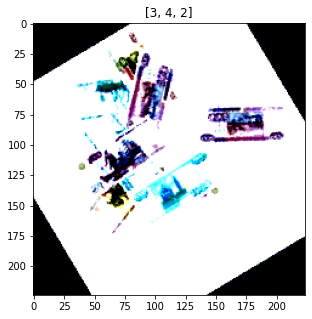

In [17]:
dataset = Dengi(train, transforms)
img, answ = dataset[np.random.randint(0, len(dataset))]
show_image(img, answ)

In [18]:
BATCH_SIZE = 8
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

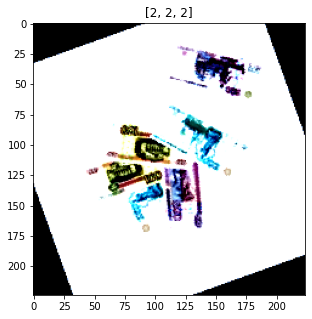

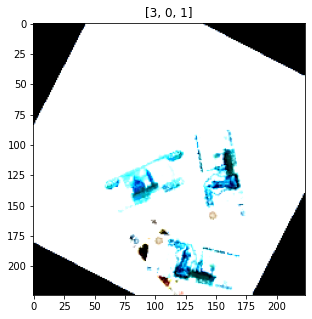

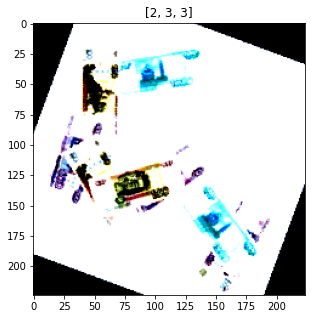

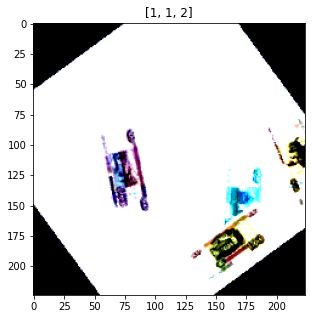

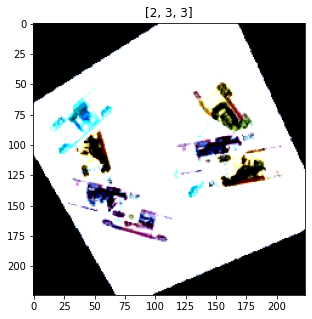

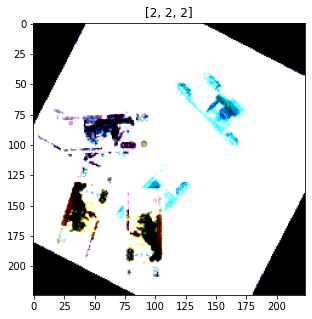

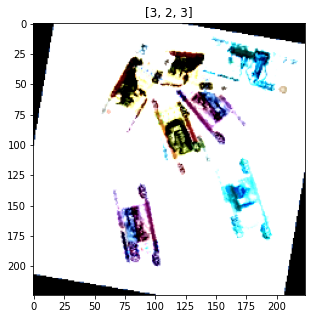

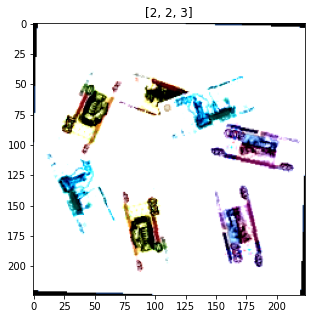

In [19]:
dataiter = iter(dataloader)
batch = next(dataiter)
imgs, moneys = batch

for i in range(BATCH_SIZE):
    img = imgs[i]
    show_image(img, list(map(lambda x: x[i].tolist(), moneys)))
    plt.show()

# Model

In [20]:
len(list(models.resnet18(pretrained=True).parameters()))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

62

In [21]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(pretrained=True)
        for param in list(resnet.parameters())[(3*len(list(resnet.parameters())))//5:]:
            param.requires_grad_(False)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.conv = nn.Sequential(nn.Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
                                  nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                                  nn.ReLU(inplace=True),
                                 )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc1 = nn.Linear(512, 100, bias=True)
        self.ac = nn.ReLU()
        self.fc2 = nn.Linear(100, 5)
        self.fc3 = nn.Linear(100, 5)
        self.fc4 = nn.Linear(100, 5)
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.reshape(-1, 512)
        x = self.fc1(x)
        x = self.ac(x)
        x1000 = self.fc2(x)
        x500 = self.fc3(x)
        x100 = self.fc4(x)
        return x1000, x500, x100       

In [22]:
model = Network()

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device).float()

loss1 = torch.nn.CrossEntropyLoss()
loss2 = torch.nn.CrossEntropyLoss()
loss3 = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

In [24]:
BATCH_SIZE = 184
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

In [25]:
valid_dataset = Dengi(valid, transforms_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

In [26]:
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")

In [27]:
def show_error(ar11, ar12, ar13, title1, ar21, ar22, ar23, title2):
    clear_output(True)
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(5)
    f.set_figwidth(10)
    
    ax1.plot(ar11, label='1000')
    ax1.plot(ar12, label='500')
    ax1.plot(ar13, label='100')
    ax1.set_title(title1)
    ax1.legend()
    
    ax2.plot(ar21, label='1000')
    ax2.plot(ar22, label='500')
    ax2.plot(ar23, label='100')
    ax2.set_title(title2)
    ax2.legend()
    
    plt.show()

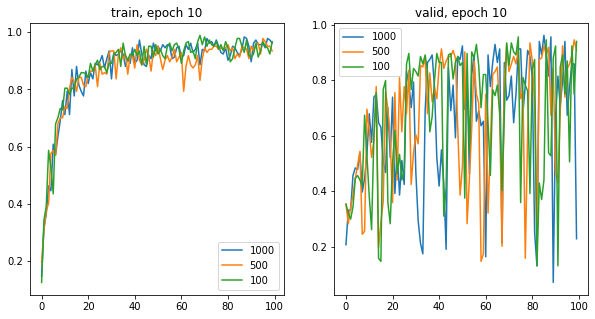

Loss: 0.46110671758651733
answer: 0 3 4
prediciton: 0 3 4
answer_val: 3 1 2
prediciton_val: 4 1 2
----------------------------


In [28]:
num_epoch = 10
error_1000 = []
error_500 = []
error_100 = []
val_1000 = []
val_500 = []
val_100 = []
print_every = 5
model.train()
for i in range(num_epoch):
     for idx, (img, money) in enumerate(iter(dataloader)):
            img, money1000, money500, money100 = (img.to(device),
                                                  money[0].to(device),
                                                  money[1].to(device),
                                                  money[2].to(device))
            
            optimizer.zero_grad()
            
            preds = model(img)
            loss_value1 = loss1(preds[0], money1000)
            loss_value2 = loss2(preds[1], money500)
            loss_value3 = loss3(preds[2], money100)
            loss_value = loss_value1 + loss_value2 + loss_value3
            loss_value.backward()
            optimizer.step()
            if idx % print_every == 0:
                model.eval()
                error_1000 += [accuracy(preds[0].argmax(dim=1).to('cpu').detach().numpy(),
                                        money1000.to('cpu').detach().numpy())]
                error_500 += [accuracy(preds[1].argmax(dim=1).to('cpu').detach().numpy(),
                                       money500.to('cpu').detach().numpy())]
                error_100 += [accuracy(preds[2].argmax(dim=1).to('cpu').detach().numpy(),
                                       money100.to('cpu').detach().numpy())]
                
                
                img_v, money_v = next(iter(valid_dataloader))
                img_v, money1000_v, money500_v, money100_v = (img_v.to(device),
                                                              money_v[0].to(device),
                                                              money_v[1].to(device),
                                                              money_v[2].to(device))
            
                preds_val = model(img_v)
                val_1000 += [accuracy(preds_val[0].argmax(dim=1).to('cpu').detach().numpy(),
                                      money1000_v.to('cpu').detach().numpy())]
                val_500 += [accuracy(preds_val[1].argmax(dim=1).to('cpu').detach().numpy(),
                                     money500_v.to('cpu').detach().numpy())]
                val_100 += [accuracy(preds_val[2].argmax(dim=1).to('cpu').detach().numpy(),
                                     money100_v.to('cpu').detach().numpy())]
                
                show_error(error_1000, error_500, error_100, f'train, epoch {i+1}',
                           val_1000, val_500, val_100, f'valid, epoch {i+1}')
                print('Loss:', loss_value.item())
                print('answer:',
                      money1000[0].item(),
                      money500[0].item(),
                      money100[0].item())
                print('prediciton:',
                      preds[0].argmax(dim=1)[0].item(),
                      preds[1].argmax(dim=1)[0].item(),
                      preds[2].argmax(dim=1)[0].item())
                print('answer_val:',
                      money1000_v[0].item(),
                      money500_v[0].item(),
                      money100_v[0].item())
                print('prediciton_val:',
                      preds_val[0].argmax(dim=1)[0].item(),
                      preds_val[1].argmax(dim=1)[0].item(),
                      preds_val[2].argmax(dim=1)[0].item())
                print('----------------------------')
                model.train()

# Prediction

In [29]:
class DengiTest(Dataset):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __len__(self):
        return 10000
    
    def __getitem__(self, idx):
        img_path = f'./test/test_{idx}.png'
        img = Image.open(img_path).convert("RGB")
        img = self.transforms(img)
        return img

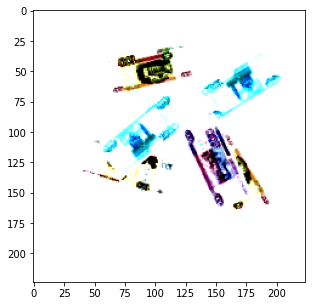

In [30]:
test_dataset = DengiTest(transforms_valid)
img = test_dataset[np.random.randint(0, len(test_dataset))]
show_image(img)

In [31]:
dataloader_test = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

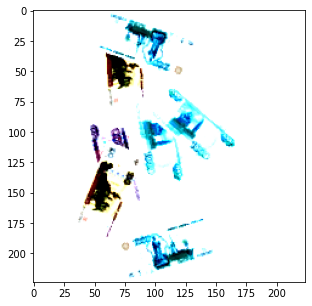

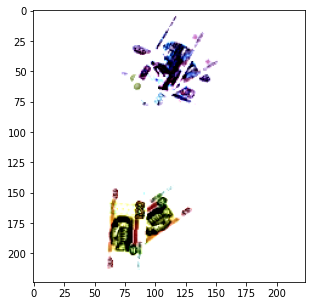

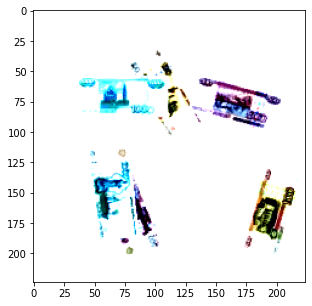

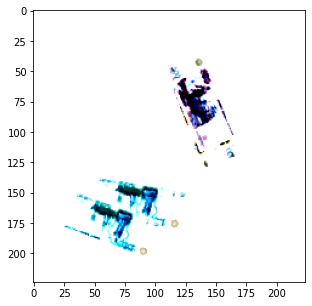

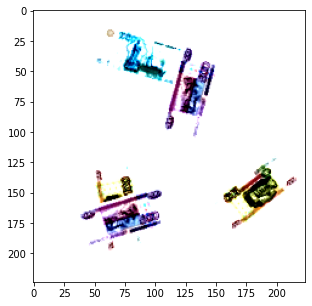

In [32]:
[show_image(img) for i, img in enumerate(next(iter(dataloader_test))) if i < 5];

In [33]:
model.eval()
preds = []
for img in iter(dataloader_test):
    img = img.to(device)
    answers = model(img)
    answers1000 = answers[0].argmax(dim=1) * 1000
    answers500 = answers[1].argmax(dim=1) * 500
    answers100 = answers[2].argmax(dim=1) * 100
    preds.extend((answers1000 + answers500 + answers100).tolist())

In [34]:
test = pd.DataFrame(preds, columns=['sum'])
test

,sum
0,4700
1,2800
2,5200
3,4700
4,3200
...,...
9995,4300
9996,3200
9997,4000
9998,6300


In [35]:
test.to_csv('test.csv', index=False)

In [36]:
torch.save(model, 'weights.pth')